In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling_test

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [6]:
#############################

perform_zscore = False

if not perform_zscore:
    zscore_str = "-no-zscore"
else:
    zscore_str = ""

#################################

In [7]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-lfp-response" + zscore_str)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [8]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [9]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [10]:
lfp_action = actions['stimulus-lfp-response' + zscore_str]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [11]:
lfp_results = pd.merge(sessions, lfp_results, how='left')

In [12]:
lfp_results = lfp_results.query('stim_location!="mecl" and stim_location!="mecr"')

In [13]:
def action_group(row):
    a = int(row.channel_group in [0,1,2,3])
    return f'{row.action}-{a}'
lfp_results['action_side_a'] = lfp_results.apply(action_group, axis=1)

In [14]:
lfp_results['stim_strength'] = lfp_results['stim_p_max'] / lfp_results['theta_energy']

In [15]:
# lfp_results_hemisphere = lfp_results.sort_values(
#     by=['action_side_a', 'stim_strength', 'signal_to_noise'], ascending=[True, False, False]
lfp_results_hemisphere = lfp_results.sort_values(
    by=['action_side_a', 'channel_group'], ascending=[True, False]
).drop_duplicates(subset='action_side_a', keep='first')
lfp_results_hemisphere.loc[:,['action_side_a','channel_group', 'signal_to_noise', 'stim_strength']].head()

,action_side_a,channel_group,signal_to_noise,stim_strength
71,1833-010719-1-0,7,0.001902,NaN
67,1833-010719-1-1,3,0.003522,NaN
695,1833-010719-2-0,7,0.004280,2.260538
691,1833-010719-2-1,3,0.003974,6.446883
583,1833-020719-1-0,7,-0.002942,NaN


In [16]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
# Hz11 means that the baseline session was indeed before an 11 Hz session
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [17]:
# prepare pairwise comparison: same animal same side same date different sessions

In [18]:
def make_entity_date_side(row):
    s = row.action_side_a.split('-')
    del s[2]
    return '-'.join(s)

In [19]:
lfp_results_hemisphere['entity_date_side'] = lfp_results_hemisphere.apply(make_entity_date_side, axis=1)

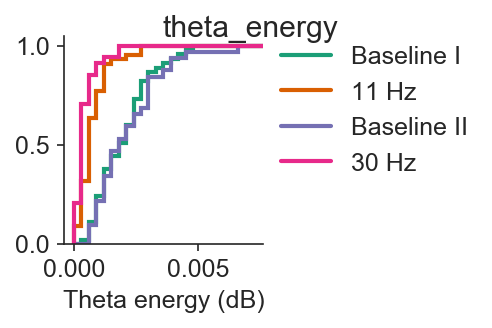

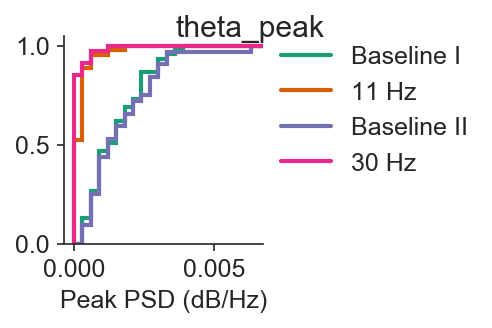

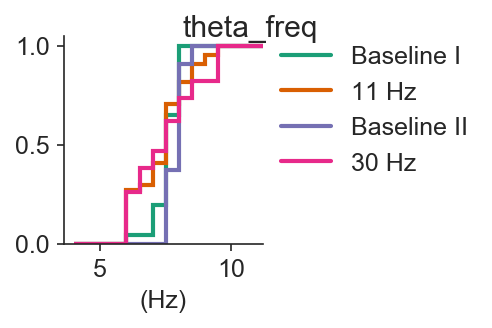

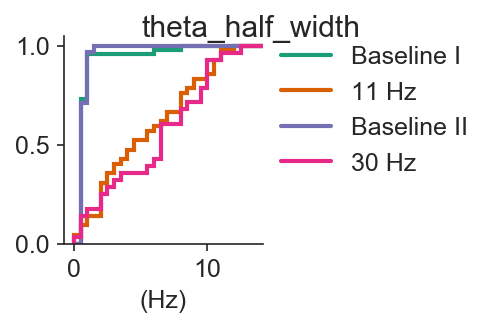

In [20]:

density = True
cumulative = True
histtype = 'step'
lw = 2
if perform_zscore:
    bins = {
        'theta_energy': np.arange(0, .7, .03),
        'theta_peak': np.arange(0, .7, .03),
        'theta_freq': np.arange(4, 10, .5),
        'theta_half_width': np.arange(0, 15, .5)
    }
else:
    bins = {
        'theta_energy': np.arange(0, .008, .0003),
        'theta_peak': np.arange(0, .007, .0003),
        'theta_freq': np.arange(4, 12, .5),
        'theta_half_width': np.arange(0, 15, .5)
    }
xlabel = {
    'theta_energy': 'Theta energy (dB)',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}
# key = 'theta_energy'
# key = 'theta_peak'
results = {}
for key in bins:
    results[key] = list()
    fig = plt.figure(figsize=(3.5,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors, queries, labels):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        values[key].hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(right=bins[key].max() - bins[key].max()*0.025)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

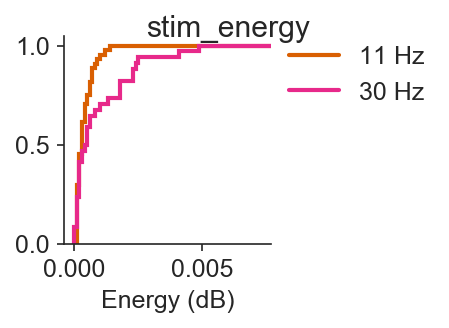

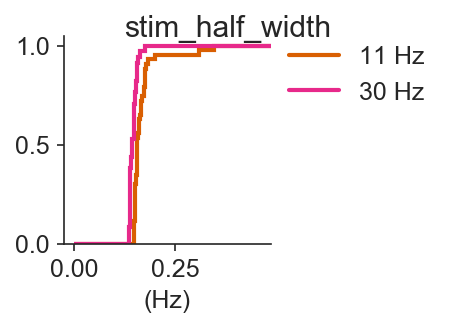

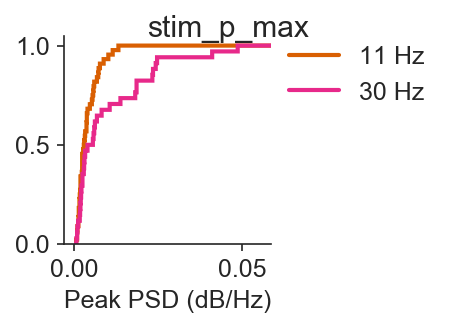

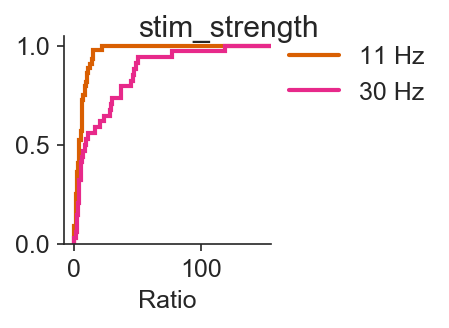

In [21]:

density = True
cumulative = True
histtype = 'step'
lw = 2
if perform_zscore:
    bins = {
        'stim_energy': np.arange(0, .7, .01),
        'stim_half_width': np.arange(0, 10, .5),
        'stim_p_max': np.arange(0, 4, .01),
        'stim_strength': np.arange(0, 160, 1)
    }
else:
    bins = {
        'stim_energy': np.arange(0, .008, .0001),
        'stim_half_width': np.arange(0, 0.5, .001),
        'stim_p_max': np.arange(0, .06, .0001),
        'stim_strength': np.arange(0, 160, 1)
    }
xlabel = {
    'stim_energy': 'Energy (dB)',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for key in bins:
    results[key] = list()
    fig = plt.figure(figsize=(3.2,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        values[key].hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(right=bins[key].max() - bins[key].max()*0.025)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

In [22]:
from functools import reduce

In [23]:
for key, val in results.items():
    df = reduce(lambda  left,right: pd.merge(left, right, on='entity_date_side', how='outer'), val)
    results[key] = df.drop('entity_date_side',axis=1)

In [24]:
def summarize(data):
    return "{:.1e} ± {:.1e} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(df, keys):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

    return "{:.2f}, {:.3f}, ({})".format(statistic, pvalue, len(dff))


def paired_t(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.ttest_rel(
        dff[keys[0]], 
        dff[keys[1]])

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)


def shapiro(df, key):
    statistic, pvalue = scipy.stats.shapiro(
        df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [25]:


stat = pd.DataFrame()

for key, df in results.items():
    Key = rename(key)
    stat[Key] = df.agg(summarize)
    stat[Key] = df.agg(summarize)

    for i, c1 in enumerate(df.columns):
        stat.loc[f'Normality {c1}', Key] = normality(df, c1)
#         stat.loc[f'Shapiro {c1}', Key] = shapiro(df, c1)
        for c2 in df.columns[i+1:]:
#             stat.loc[f'MWU {c1} {c2}', Key] = MWU(df, [c1, c2])
#             stat.loc[f'PRS {c1} {c2}', Key] = PRS(df, [c1, c2])
            stat.loc[f'Wilcoxon {c1} {c2}', Key] = wilcoxon(df, [c1, c2])
#             stat.loc[f'Paired T {c1} {c2}', Key] = paired_t(df, [c1, c2])

stat.sort_index()

,Theta energy,Theta peak,Theta freq,Theta half width,Stim energy,Stim half width,Stim p max,Stim strength
11 Hz,9.1e-04 ± 9.0e-05 (44),3.9e-04 ± 5.1e-05 (44),7.5e+00 ± 1.5e-01 (44),5.5e+00 ± 5.6e-01 (42),4.3e-04 ± 4.7e-05 (44),1.8e-01 ± 1.3e-02 (44),3.9e-03 ± 4.5e-04 (44),5.8e+00 ± 7.3e-01 (44)
30 Hz,5.7e-04 ± 7.0e-05 (34),2.5e-04 ± 4.3e-05 (34),7.7e+00 ± 2.1e-01 (34),6.7e+00 ± 8.4e-01 (29),1.0e-03 ± 2.1e-04 (34),1.5e-01 ± 1.6e-03 (34),1.0e-02 ± 2.0e-03 (34),2.2e+01 ± 4.5e+00 (34)
Baseline I,2.3e-03 ± 2.2e-04 (46),1.8e-03 ± 1.9e-04 (46),7.7e+00 ± 6.3e-02 (46),1.2e+00 ± 2.0e-01 (45),NaN,NaN,NaN,NaN
Baseline II,2.3e-03 ± 2.4e-04 (32),1.8e-03 ± 2.3e-04 (32),8.1e+00 ± 4.7e-02 (32),9.1e-01 ± 3.9e-02 (31),NaN,NaN,NaN,NaN
Normality 11 Hz,"27.15, 0.000","57.06, 0.000","1.61, 0.447","11.89, 0.003","16.86, 0.000","82.50, 0.000","14.96, 0.001","15.95, 0.000"
Normality 30 Hz,"30.23, 0.000","43.50, 0.000","4.85, 0.088","5.64, 0.060","19.73, 0.000","9.69, 0.008","19.72, 0.000","25.38, 0.000"
Normality Baseline I,"41.33, 0.000","32.43, 0.000","25.20, 0.000","74.91, 0.000",NaN,NaN,NaN,NaN
Normality Baseline II,"13.17, 0.001","20.78, 0.000","0.96, 0.618","13.33, 0.001",NaN,NaN,NaN,NaN
Wilcoxon 11 Hz 30 Hz,"118.00, 0.006, (32)","134.00, 0.015, (32)","164.00, 0.247, (32)","143.00, 0.269, (27)","173.00, 0.089, (32)","25.00, 0.000, (32)","157.00, 0.045, (32)","105.00, 0.003, (32)"
Wilcoxon 11 Hz Baseline II,"11.00, 0.000, (32)","5.00, 0.000, (32)","60.00, 0.000, (32)","3.00, 0.000, (30)",NaN,NaN,NaN,NaN


In [26]:
stat.to_latex(output_path / "statistics" / "statistics.tex")
stat.to_csv(output_path / "statistics" / "statistics.csv")

# Plot PSD

In [27]:
psd = pd.read_feather(output_path / 'data' / 'psd.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [28]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [29]:
freq = freqs.T.iloc[0].values

mask = (freq < 49)

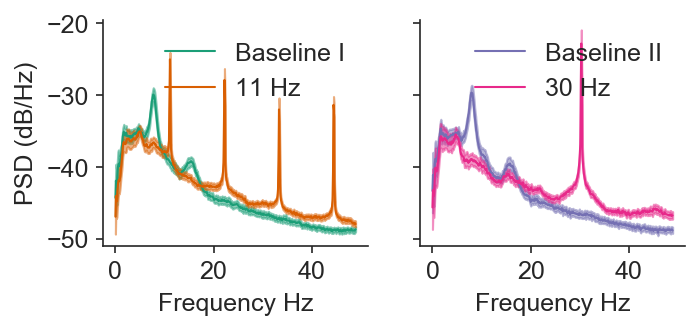

In [30]:

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
axs = axs.repeat(2)
for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
    selection = [
        f'{r.action}_{r.channel_group}' 
        for i, r in lfp_results_hemisphere.query(query).iterrows()]
    values = psd.loc[mask, selection].to_numpy()
    values = 10 * np.log10(values)
    plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#     ax.set_title(titles[i])
    ax.set_xlabel('Frequency Hz')
    ax.legend(frameon=False)
axs[0].set_ylabel('PSD (dB/Hz)')
# axs[0].set_ylim(-31, 1)
despine()

figname = 'lfp-psd'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [31]:
action = project.require_action("stimulus-lfp-response" + zscore_str)

In [32]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/data/psd.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/data/freqs.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/figures/lfp-psd-histogram-stim_energy.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/figures/lfp-psd-histogram-stim_strength.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/figures/lfp-psd.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/figures/lfp-psd-histogram-theta_peak.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-no-zscore/data/figures/lfp-psd-histogram-sti

In [33]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-lfp-response.ipynb")